In [1]:
%autosave 60

Autosaving every 60 seconds


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score, precision_recall_curve
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from catboost import Pool
from catboost.utils import select_threshold

import warnings 
warnings.filterwarnings('ignore')

In [3]:
df_true = pd.read_csv('train.csv')
df_test_true = pd.read_csv('test.csv')

In [4]:
df = df_true.copy()
df_test = df_test_true.copy()


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010248 entries, 0 to 1010247
Data columns (total 19 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   client_id           1010248 non-null  int64  
 1   регион              612396 non-null   object 
 2   использование       1010248 non-null  object 
 3   сумма               655354 non-null   float64
 4   частота_пополнения  655354 non-null   float64
 5   доход               669787 non-null   float64
 6   сегмент_arpu        669787 non-null   float64
 7   частота             669787 non-null   float64
 8   объем_данных        512886 non-null   float64
 9   on_net              641315 non-null   float64
 10  продукт_1           590287 non-null   float64
 11  продукт_2           405005 non-null   float64
 12  зона_1              79807 non-null    float64
 13  зона_2              64000 non-null    float64
 14  mrg_                1010248 non-null  bool   
 15  секретный_скор 

In [6]:
df.describe()

,client_id,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,зона_1,зона_2,секретный_скор,pack_freq,binary_target
count,1.010248e+06,655354.000000,655354.000000,669787.000000,669787.000000,669787.000000,512886.000000,641315.000000,590287.000000,405005.000000,79807.000000,64000.000000,1.010248e+06,586973.000000,1.010248e+06
mean,5.051235e+05,41.418633,11.500826,42842.276282,782.594890,3.276499,34.336000,277.221033,95.222444,23.115112,0.001691,0.234682,4.433381e-01,2.599410,1.873649e-01
std,2.916336e+05,25.314037,13.247311,14430.607285,1015.343387,1.789887,46.795739,873.132377,202.602980,63.040553,0.008810,0.974284,3.651556e-01,1.577391,3.902044e-01
min,0.000000e+00,2.924038,1.000000,5726.010183,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,1.000000,0.000000e+00
25%,2.525618e+05,20.672445,2.000000,32149.996445,142.310000,1.732051,0.000000,5.000000,7.000000,2.000000,0.000000,0.000000,8.196721e-02,1.414214,0.000000e+00
50%,5.051235e+05,35.805726,6.000000,42311.774838,427.350000,3.000000,16.000000,27.000000,29.000000,6.000000,0.000209,0.063633,3.770492e-01,2.236068,0.000000e+00
75%,7.576852e+05,55.853917,16.000000,52934.419983,1047.010000,4.472136,53.656314,156.000000,99.000000,20.000000,0.000626,0.159084,8.196721e-01,3.464102,0.000000e+00
max,1.010247e+06,336.523194,133.000000,129843.989985,37898.720000,9.539392,1304.725642,50809.000000,12040.000000,4174.000000,1.000000,100.000000,1.000000e+00,25.079872,1.000000e+00


In [7]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

client_id - 0%
регион - 39%
использование - 0%
сумма - 35%
частота_пополнения - 35%
доход - 34%
сегмент_arpu - 34%
частота - 34%
объем_данных - 49%
on_net - 37%
продукт_1 - 42%
продукт_2 - 60%
зона_1 - 92%
зона_2 - 94%
mrg_ - 0%
секретный_скор - 0%
pack - 42%
pack_freq - 42%
binary_target - 0%


Удалим столбцы с большим количеством пропусков, с одним уникальным значением.

In [8]:
df = df.drop(['client_id', 'зона_1', 'зона_2', 'mrg_'], axis=1)
df_test = df_test.drop(['client_id', 'зона_1', 'зона_2','mrg_'], axis=1)

In [9]:
df

,регион,использование,сумма,частота_пополнения,доход,сегмент_arpu,частота,объем_данных,on_net,продукт_1,продукт_2,секретный_скор,pack,pack_freq,binary_target
0,Уран,>24LY,14.617797,1.0,27034.974914,71.37,1.000000,NaN,26.0,10.0,NaN,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1,Марс,>24LY,32.686083,3.0,40373.828300,354.27,2.000000,35.679126,45.0,8.0,NaN,0.573770,тариф_a 250 (условие) _безлим_c_output_сутки,1.414214,0
2,Церера,>24LY,25.318570,3.0,32004.378374,139.74,1.414214,NaN,NaN,13.0,NaN,0.131148,NaN,NaN,0
3,Марс,>24LY,70.710678,38.0,59953.505011,1722.65,6.403124,163.309522,203.0,274.0,NaN,0.885246,"трафик: 100 (условие) 40mb,_сутки",4.000000,0
4,Меркурий,>24LY,9.244999,2.0,21499.998428,28.63,1.414214,5.000000,NaN,NaN,NaN,0.344262,"трафик: 100 (условие) 40mb,_сутки",1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010243,Марс,>24LY,73.088166,19.0,57900.865741,1498.72,4.582576,NaN,80.0,258.0,2.0,0.934426,_output-_сеть 500 (условие) 2000f;5d,4.242641,0
1010244,Марс,>24LY,20.672445,2.0,32166.158933,142.74,2.645751,NaN,25.0,2.0,5.0,0.540984,_output-_сеть 500 (условие) 2000f;5d,1.000000,0
1010245,Земля,>24LY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.049180,NaN,NaN,1
1010246,Солнце,>24LY,66.986417,10.0,56223.620819,1332.48,4.123106,NaN,62.0,31.0,29.0,1.000000,_соц_u2opia_weekly,1.000000,0


In [10]:
categ = ['регион', 'использование', 'pack']
numer = ['сумма', 'частота_пополнения', 'доход','сегмент_arpu', 'частота', 'объем_данных', 'on_net', 'продукт_1',
        'продукт_2','секретный_скор', 'pack_freq']

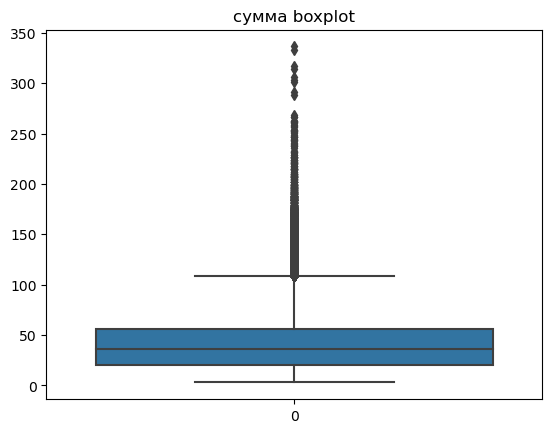

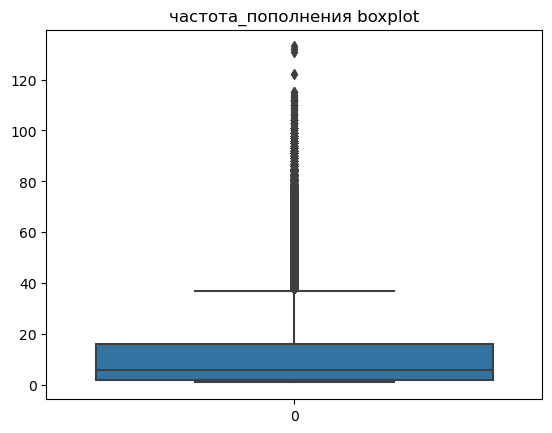

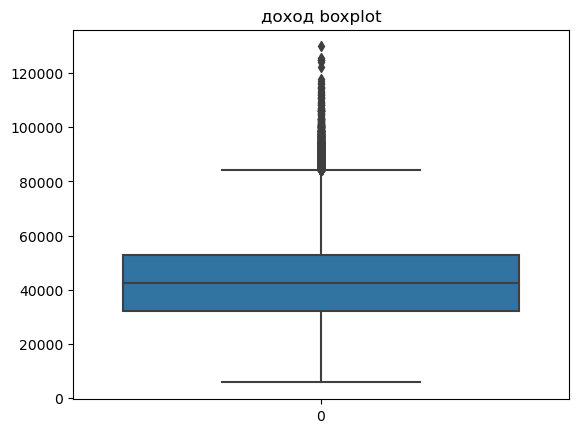

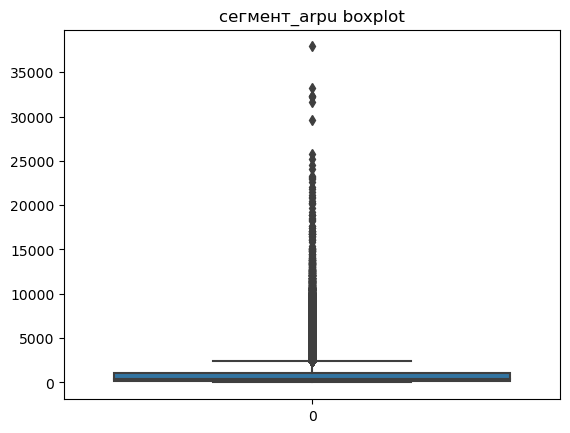

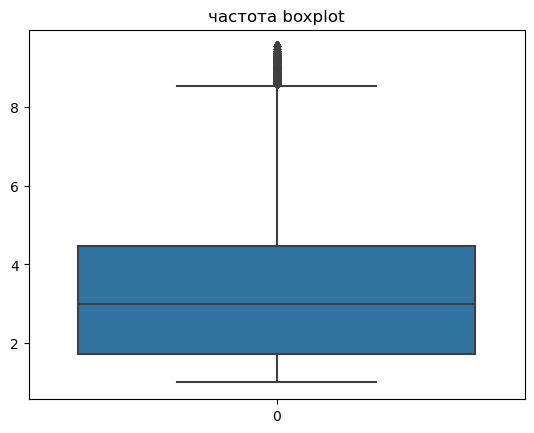

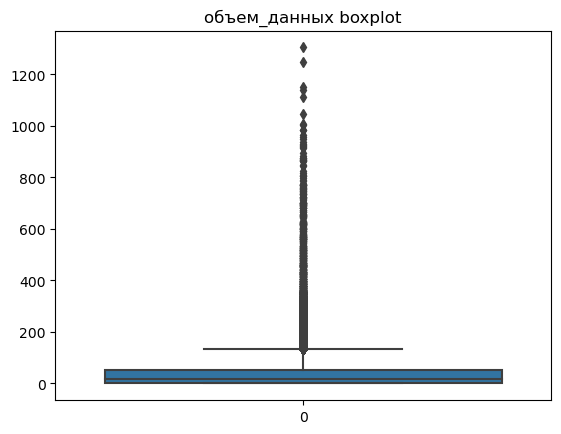

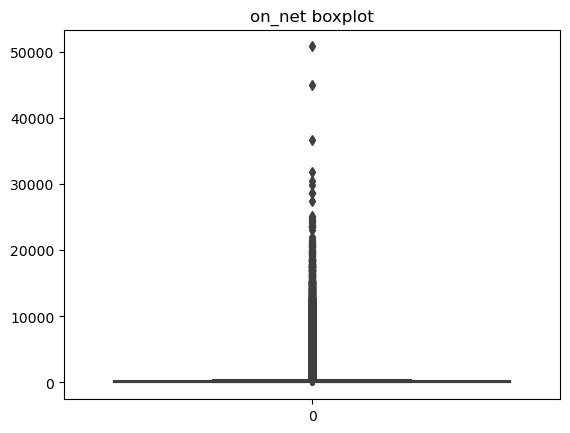

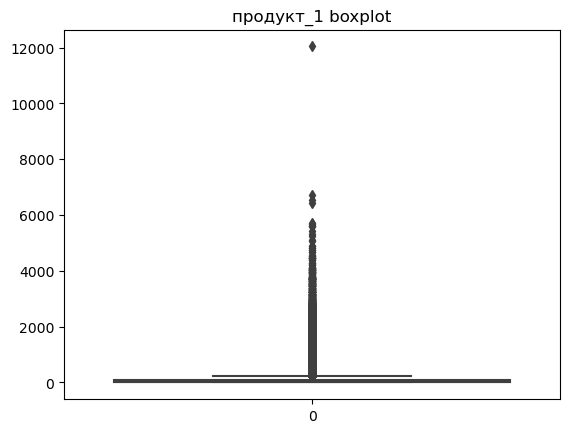

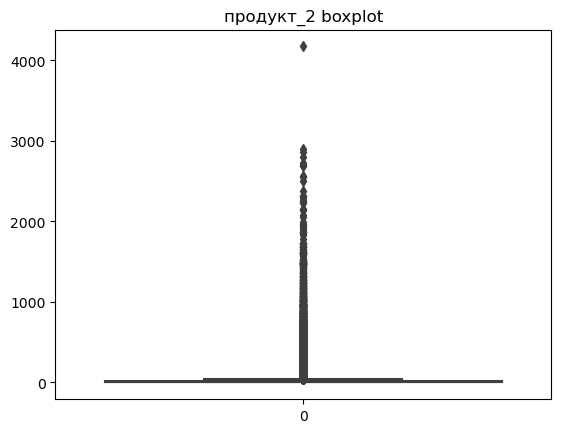

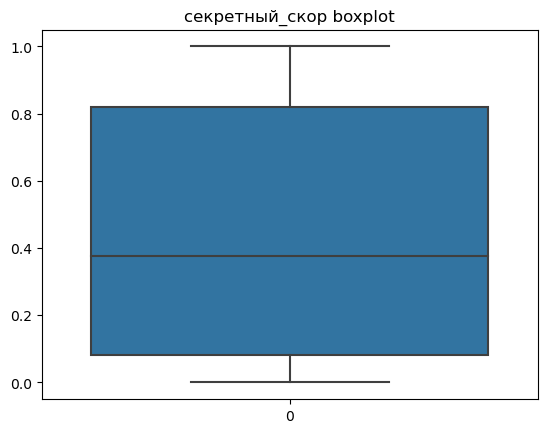

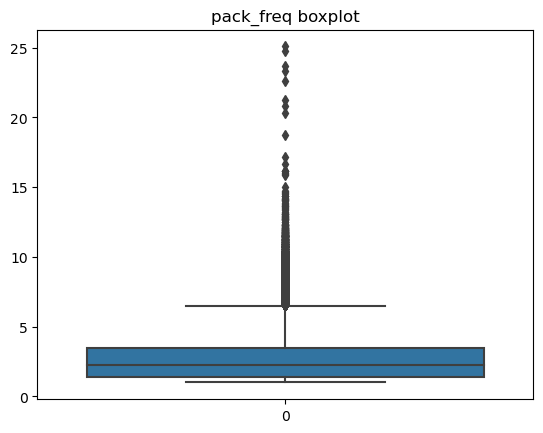

In [11]:
for col in numer:
    plt.title(f'{col} boxplot')
    sns.boxplot(df[col], )
    plt.show()

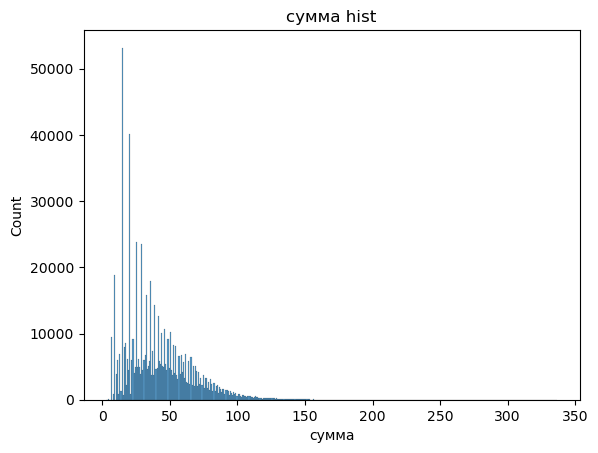

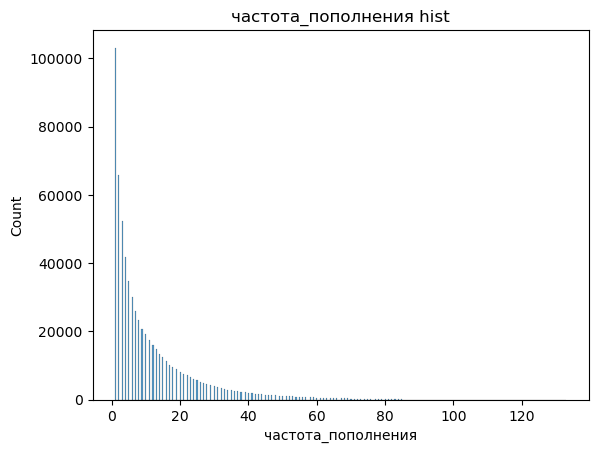

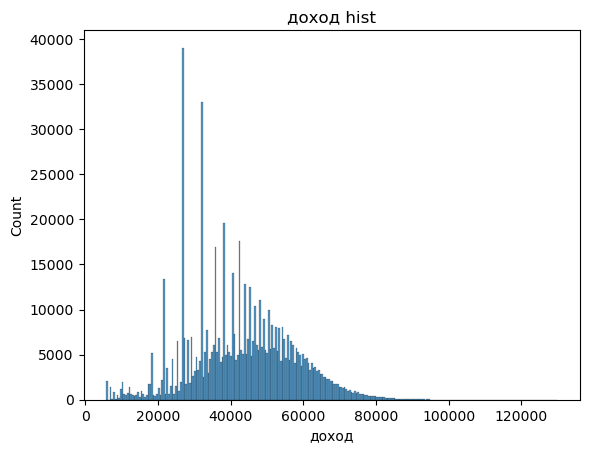

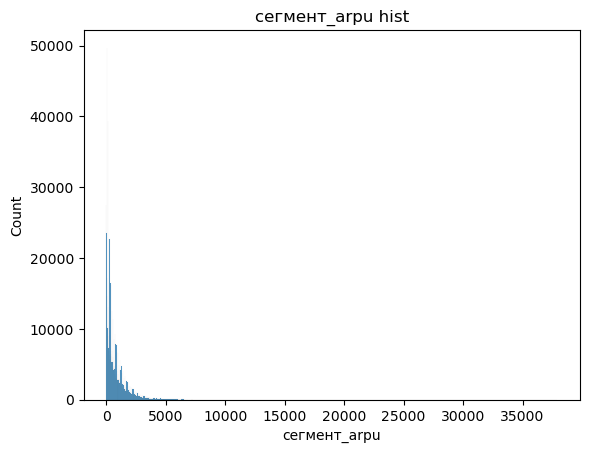

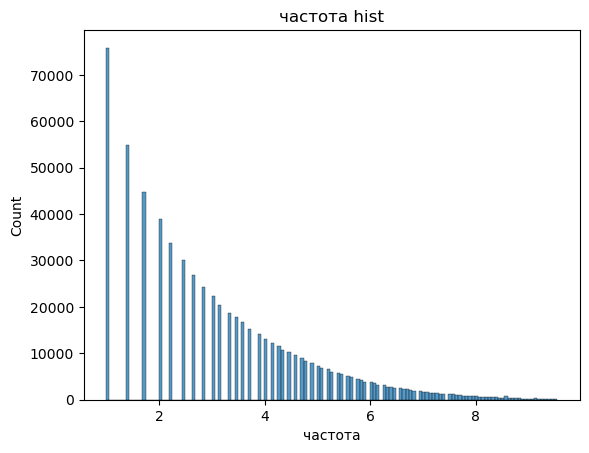

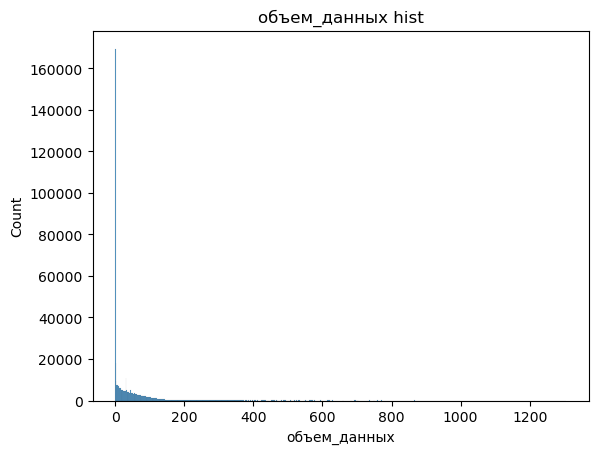

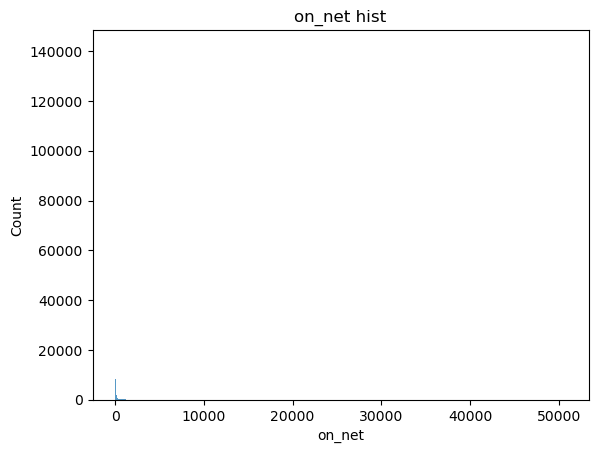

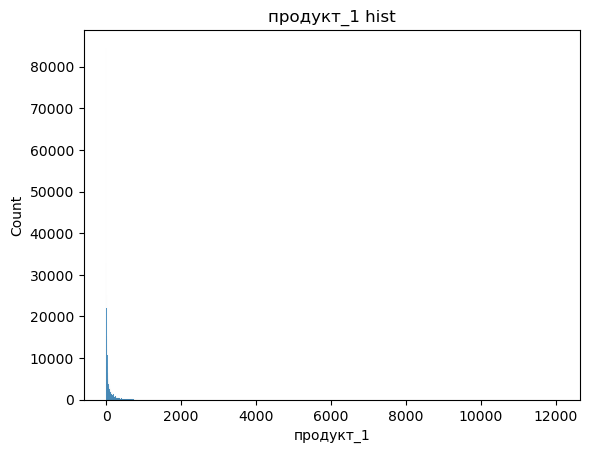

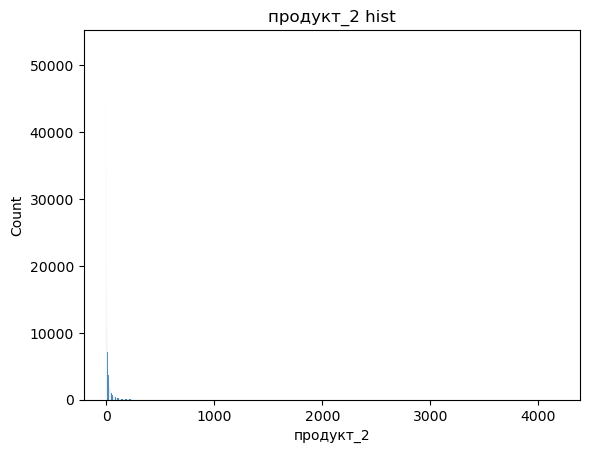

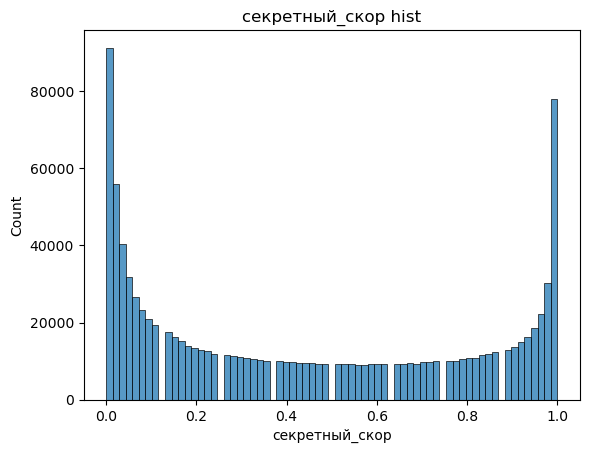

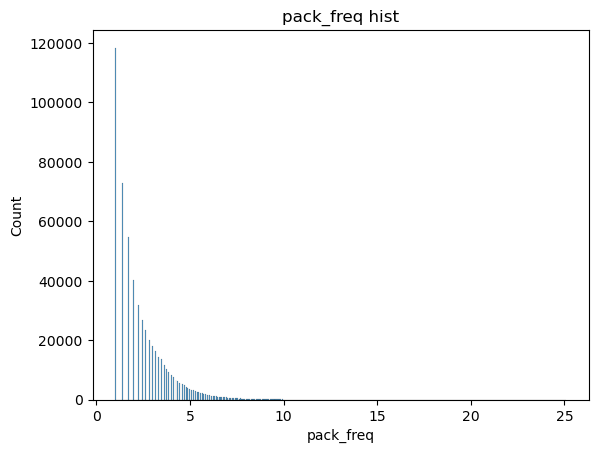

In [12]:
for col in numer:
    plt.title(f'{col} hist')
    sns.histplot(df[col])
    plt.show()

In [13]:
for col in categ:
    df[col] = df[col].fillna('missed')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
for col in numer:
    df[col] = imp_mean.fit_transform(df[col].values.reshape(-1,1))
    
    
for col in categ:
    df_test[col] = df_test[col].fillna('missed')

imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
for col in numer:
    df_test[col] = imp_mean.fit_transform(df_test[col].values.reshape(-1,1))
    

<Axes: >

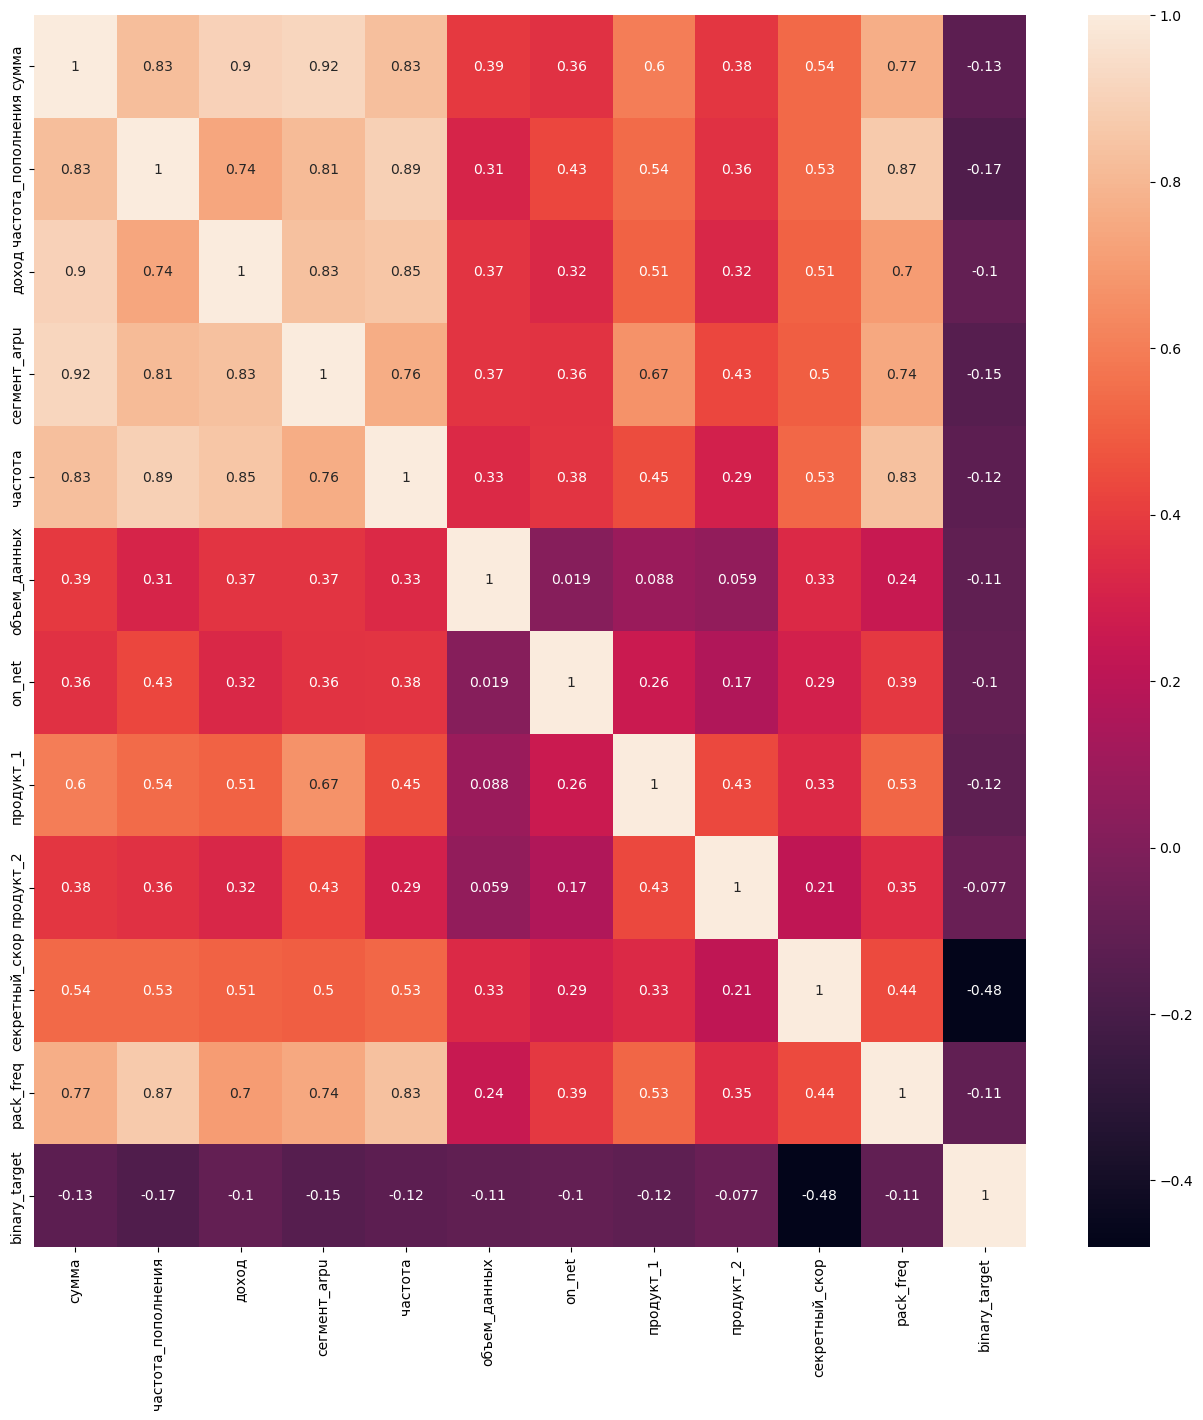

In [14]:
plt.figure(figsize=(16,16))
sns.heatmap(df.corr(), annot=True)

## Обучение модели

**CatBoost + CalibratedClassifierCV**

In [15]:
X, y = df.drop('binary_target', axis=1), df['binary_target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=43, stratify=y)

model_cat = CatBoostClassifier(random_state=2, depth=4, iterations=800, cat_features=categ, eval_metric='F1', auto_class_weights='SqrtBalanced')

calibrated_clf = CalibratedClassifierCV(model_cat, cv=3, method='isotonic')
model_cat = calibrated_clf.fit(X_train, y_train)

pred_cat = model_cat.predict(X_test)
print('cat', f1_score(y_test, pred_cat))

Learning rate set to 0.185404
0:	learn: 0.7481204	total: 483ms	remaining: 6m 26s
1:	learn: 0.7371027	total: 872ms	remaining: 5m 48s
2:	learn: 0.7384772	total: 1.52s	remaining: 6m 44s
3:	learn: 0.7390455	total: 2.06s	remaining: 6m 50s
4:	learn: 0.7384207	total: 2.63s	remaining: 6m 57s
5:	learn: 0.7374568	total: 2.93s	remaining: 6m 28s
6:	learn: 0.7466607	total: 3.28s	remaining: 6m 11s
7:	learn: 0.7465736	total: 3.68s	remaining: 6m 4s
8:	learn: 0.7466679	total: 3.98s	remaining: 5m 49s
9:	learn: 0.7464907	total: 4.37s	remaining: 5m 45s
10:	learn: 0.7456934	total: 4.7s	remaining: 5m 37s
11:	learn: 0.7444040	total: 5.02s	remaining: 5m 29s
12:	learn: 0.7441694	total: 5.63s	remaining: 5m 41s
13:	learn: 0.7448079	total: 5.91s	remaining: 5m 32s
14:	learn: 0.7451171	total: 6.2s	remaining: 5m 24s
15:	learn: 0.7458051	total: 6.48s	remaining: 5m 17s
16:	learn: 0.7458459	total: 6.76s	remaining: 5m 11s
17:	learn: 0.7460265	total: 6.99s	remaining: 5m 3s
18:	learn: 0.7460787	total: 7.24s	remaining: 4m 

159:	learn: 0.7461894	total: 43.7s	remaining: 2m 54s
160:	learn: 0.7461964	total: 43.9s	remaining: 2m 54s
161:	learn: 0.7461814	total: 44.1s	remaining: 2m 53s
162:	learn: 0.7461647	total: 44.4s	remaining: 2m 53s
163:	learn: 0.7461383	total: 44.6s	remaining: 2m 53s
164:	learn: 0.7461163	total: 44.9s	remaining: 2m 52s
165:	learn: 0.7461621	total: 45.1s	remaining: 2m 52s
166:	learn: 0.7461471	total: 45.4s	remaining: 2m 52s
167:	learn: 0.7461630	total: 45.7s	remaining: 2m 51s
168:	learn: 0.7461920	total: 46s	remaining: 2m 51s
169:	learn: 0.7461920	total: 46.3s	remaining: 2m 51s
170:	learn: 0.7461990	total: 46.6s	remaining: 2m 51s
171:	learn: 0.7461982	total: 46.8s	remaining: 2m 50s
172:	learn: 0.7462140	total: 47.1s	remaining: 2m 50s
173:	learn: 0.7462720	total: 47.5s	remaining: 2m 50s
174:	learn: 0.7462641	total: 47.7s	remaining: 2m 50s
175:	learn: 0.7462527	total: 47.9s	remaining: 2m 49s
176:	learn: 0.7462474	total: 48.2s	remaining: 2m 49s
177:	learn: 0.7462474	total: 48.4s	remaining: 2m

314:	learn: 0.7467772	total: 1m 21s	remaining: 2m 4s
315:	learn: 0.7467974	total: 1m 21s	remaining: 2m 4s
316:	learn: 0.7468053	total: 1m 21s	remaining: 2m 4s
317:	learn: 0.7467947	total: 1m 21s	remaining: 2m 3s
318:	learn: 0.7468212	total: 1m 21s	remaining: 2m 3s
319:	learn: 0.7468282	total: 1m 22s	remaining: 2m 3s
320:	learn: 0.7468317	total: 1m 22s	remaining: 2m 3s
321:	learn: 0.7468220	total: 1m 22s	remaining: 2m 2s
322:	learn: 0.7468413	total: 1m 22s	remaining: 2m 2s
323:	learn: 0.7468703	total: 1m 22s	remaining: 2m 1s
324:	learn: 0.7468685	total: 1m 23s	remaining: 2m 1s
325:	learn: 0.7468720	total: 1m 23s	remaining: 2m 1s
326:	learn: 0.7468861	total: 1m 23s	remaining: 2m
327:	learn: 0.7469600	total: 1m 23s	remaining: 2m
328:	learn: 0.7469529	total: 1m 24s	remaining: 2m
329:	learn: 0.7469231	total: 1m 24s	remaining: 1m 59s
330:	learn: 0.7469021	total: 1m 24s	remaining: 1m 59s
331:	learn: 0.7469196	total: 1m 24s	remaining: 1m 59s
332:	learn: 0.7469732	total: 1m 24s	remaining: 1m 59

467:	learn: 0.7474780	total: 1m 59s	remaining: 1m 24s
468:	learn: 0.7474640	total: 1m 59s	remaining: 1m 24s
469:	learn: 0.7474912	total: 1m 59s	remaining: 1m 24s
470:	learn: 0.7475019	total: 2m	remaining: 1m 23s
471:	learn: 0.7475063	total: 2m	remaining: 1m 23s
472:	learn: 0.7475853	total: 2m	remaining: 1m 23s
473:	learn: 0.7475950	total: 2m 1s	remaining: 1m 23s
474:	learn: 0.7475978	total: 2m 1s	remaining: 1m 23s
475:	learn: 0.7475758	total: 2m 1s	remaining: 1m 22s
476:	learn: 0.7476427	total: 2m 1s	remaining: 1m 22s
477:	learn: 0.7476488	total: 2m 1s	remaining: 1m 22s
478:	learn: 0.7476462	total: 2m 2s	remaining: 1m 21s
479:	learn: 0.7476524	total: 2m 2s	remaining: 1m 21s
480:	learn: 0.7476656	total: 2m 2s	remaining: 1m 21s
481:	learn: 0.7476674	total: 2m 2s	remaining: 1m 21s
482:	learn: 0.7476938	total: 2m 3s	remaining: 1m 20s
483:	learn: 0.7476937	total: 2m 3s	remaining: 1m 20s
484:	learn: 0.7477079	total: 2m 3s	remaining: 1m 20s
485:	learn: 0.7476886	total: 2m 3s	remaining: 1m 19s

622:	learn: 0.7482802	total: 2m 34s	remaining: 44s
623:	learn: 0.7482890	total: 2m 35s	remaining: 43.8s
624:	learn: 0.7482925	total: 2m 35s	remaining: 43.5s
625:	learn: 0.7483405	total: 2m 35s	remaining: 43.2s
626:	learn: 0.7483423	total: 2m 35s	remaining: 43s
627:	learn: 0.7483528	total: 2m 35s	remaining: 42.7s
628:	learn: 0.7483275	total: 2m 36s	remaining: 42.5s
629:	learn: 0.7483196	total: 2m 36s	remaining: 42.2s
630:	learn: 0.7483011	total: 2m 36s	remaining: 41.9s
631:	learn: 0.7483117	total: 2m 36s	remaining: 41.7s
632:	learn: 0.7483302	total: 2m 37s	remaining: 41.4s
633:	learn: 0.7483320	total: 2m 37s	remaining: 41.2s
634:	learn: 0.7483188	total: 2m 37s	remaining: 40.9s
635:	learn: 0.7483346	total: 2m 37s	remaining: 40.7s
636:	learn: 0.7483198	total: 2m 37s	remaining: 40.4s
637:	learn: 0.7483366	total: 2m 38s	remaining: 40.2s
638:	learn: 0.7483006	total: 2m 38s	remaining: 39.9s
639:	learn: 0.7483111	total: 2m 38s	remaining: 39.6s
640:	learn: 0.7483217	total: 2m 38s	remaining: 39.

778:	learn: 0.7490479	total: 3m 11s	remaining: 5.17s
779:	learn: 0.7490724	total: 3m 12s	remaining: 4.92s
780:	learn: 0.7490734	total: 3m 12s	remaining: 4.68s
781:	learn: 0.7490425	total: 3m 12s	remaining: 4.43s
782:	learn: 0.7490620	total: 3m 12s	remaining: 4.19s
783:	learn: 0.7490814	total: 3m 13s	remaining: 3.94s
784:	learn: 0.7490707	total: 3m 13s	remaining: 3.7s
785:	learn: 0.7490919	total: 3m 13s	remaining: 3.45s
786:	learn: 0.7490989	total: 3m 14s	remaining: 3.2s
787:	learn: 0.7491298	total: 3m 14s	remaining: 2.96s
788:	learn: 0.7491298	total: 3m 14s	remaining: 2.71s
789:	learn: 0.7491244	total: 3m 14s	remaining: 2.46s
790:	learn: 0.7491015	total: 3m 15s	remaining: 2.22s
791:	learn: 0.7490874	total: 3m 15s	remaining: 1.97s
792:	learn: 0.7491328	total: 3m 15s	remaining: 1.73s
793:	learn: 0.7491574	total: 3m 15s	remaining: 1.48s
794:	learn: 0.7491759	total: 3m 15s	remaining: 1.23s
795:	learn: 0.7491883	total: 3m 16s	remaining: 986ms
796:	learn: 0.7491900	total: 3m 16s	remaining: 7

135:	learn: 0.7420508	total: 30.2s	remaining: 2m 27s
136:	learn: 0.7420461	total: 30.4s	remaining: 2m 27s
137:	learn: 0.7421459	total: 30.6s	remaining: 2m 26s
138:	learn: 0.7421684	total: 30.9s	remaining: 2m 26s
139:	learn: 0.7421853	total: 31.1s	remaining: 2m 26s
140:	learn: 0.7422365	total: 31.3s	remaining: 2m 26s
141:	learn: 0.7422392	total: 31.5s	remaining: 2m 25s
142:	learn: 0.7422392	total: 31.7s	remaining: 2m 25s
143:	learn: 0.7422240	total: 31.8s	remaining: 2m 25s
144:	learn: 0.7422837	total: 32.1s	remaining: 2m 24s
145:	learn: 0.7422998	total: 32.3s	remaining: 2m 24s
146:	learn: 0.7422813	total: 32.5s	remaining: 2m 24s
147:	learn: 0.7423136	total: 32.7s	remaining: 2m 23s
148:	learn: 0.7423296	total: 32.9s	remaining: 2m 23s
149:	learn: 0.7423919	total: 33.1s	remaining: 2m 23s
150:	learn: 0.7423753	total: 33.3s	remaining: 2m 23s
151:	learn: 0.7423955	total: 33.5s	remaining: 2m 22s
152:	learn: 0.7424016	total: 33.7s	remaining: 2m 22s
153:	learn: 0.7424034	total: 33.9s	remaining: 

292:	learn: 0.7432087	total: 1m 3s	remaining: 1m 50s
293:	learn: 0.7432007	total: 1m 4s	remaining: 1m 50s
294:	learn: 0.7432114	total: 1m 4s	remaining: 1m 50s
295:	learn: 0.7432221	total: 1m 4s	remaining: 1m 49s
296:	learn: 0.7432327	total: 1m 4s	remaining: 1m 49s
297:	learn: 0.7432274	total: 1m 5s	remaining: 1m 49s
298:	learn: 0.7432255	total: 1m 5s	remaining: 1m 49s
299:	learn: 0.7432335	total: 1m 5s	remaining: 1m 49s
300:	learn: 0.7432844	total: 1m 5s	remaining: 1m 48s
301:	learn: 0.7432992	total: 1m 5s	remaining: 1m 48s
302:	learn: 0.7433258	total: 1m 6s	remaining: 1m 48s
303:	learn: 0.7433142	total: 1m 6s	remaining: 1m 48s
304:	learn: 0.7433132	total: 1m 6s	remaining: 1m 48s
305:	learn: 0.7432835	total: 1m 6s	remaining: 1m 47s
306:	learn: 0.7433193	total: 1m 7s	remaining: 1m 47s
307:	learn: 0.7433336	total: 1m 7s	remaining: 1m 47s
308:	learn: 0.7432960	total: 1m 7s	remaining: 1m 47s
309:	learn: 0.7433165	total: 1m 7s	remaining: 1m 47s
310:	learn: 0.7433183	total: 1m 7s	remaining: 

445:	learn: 0.7445971	total: 1m 38s	remaining: 1m 17s
446:	learn: 0.7445997	total: 1m 38s	remaining: 1m 17s
447:	learn: 0.7446086	total: 1m 38s	remaining: 1m 17s
448:	learn: 0.7445944	total: 1m 38s	remaining: 1m 17s
449:	learn: 0.7446325	total: 1m 39s	remaining: 1m 17s
450:	learn: 0.7446263	total: 1m 39s	remaining: 1m 16s
451:	learn: 0.7446237	total: 1m 39s	remaining: 1m 16s
452:	learn: 0.7446317	total: 1m 39s	remaining: 1m 16s
453:	learn: 0.7446292	total: 1m 40s	remaining: 1m 16s
454:	learn: 0.7446258	total: 1m 40s	remaining: 1m 16s
455:	learn: 0.7446586	total: 1m 40s	remaining: 1m 15s
456:	learn: 0.7446657	total: 1m 40s	remaining: 1m 15s
457:	learn: 0.7446798	total: 1m 40s	remaining: 1m 15s
458:	learn: 0.7446595	total: 1m 41s	remaining: 1m 15s
459:	learn: 0.7446443	total: 1m 41s	remaining: 1m 14s
460:	learn: 0.7446586	total: 1m 41s	remaining: 1m 14s
461:	learn: 0.7446878	total: 1m 41s	remaining: 1m 14s
462:	learn: 0.7447099	total: 1m 42s	remaining: 1m 14s
463:	learn: 0.7447612	total:

602:	learn: 0.7454020	total: 2m 17s	remaining: 44.9s
603:	learn: 0.7453958	total: 2m 17s	remaining: 44.7s
604:	learn: 0.7453435	total: 2m 17s	remaining: 44.4s
605:	learn: 0.7453630	total: 2m 18s	remaining: 44.2s
606:	learn: 0.7453798	total: 2m 18s	remaining: 44s
607:	learn: 0.7454091	total: 2m 18s	remaining: 43.7s
608:	learn: 0.7453869	total: 2m 18s	remaining: 43.5s
609:	learn: 0.7454835	total: 2m 18s	remaining: 43.3s
610:	learn: 0.7454454	total: 2m 19s	remaining: 43s
611:	learn: 0.7454099	total: 2m 19s	remaining: 42.8s
612:	learn: 0.7454231	total: 2m 19s	remaining: 42.6s
613:	learn: 0.7454409	total: 2m 19s	remaining: 42.3s
614:	learn: 0.7454347	total: 2m 19s	remaining: 42.1s
615:	learn: 0.7454383	total: 2m 20s	remaining: 41.9s
616:	learn: 0.7454330	total: 2m 20s	remaining: 41.6s
617:	learn: 0.7454259	total: 2m 20s	remaining: 41.4s
618:	learn: 0.7454817	total: 2m 20s	remaining: 41.2s
619:	learn: 0.7455029	total: 2m 21s	remaining: 41s
620:	learn: 0.7454683	total: 2m 21s	remaining: 40.7s

758:	learn: 0.7475465	total: 2m 51s	remaining: 9.28s
759:	learn: 0.7475596	total: 2m 52s	remaining: 9.06s
760:	learn: 0.7475676	total: 2m 52s	remaining: 8.83s
761:	learn: 0.7475940	total: 2m 52s	remaining: 8.6s
762:	learn: 0.7475773	total: 2m 52s	remaining: 8.38s
763:	learn: 0.7475711	total: 2m 52s	remaining: 8.15s
764:	learn: 0.7476063	total: 2m 53s	remaining: 7.92s
765:	learn: 0.7475913	total: 2m 53s	remaining: 7.7s
766:	learn: 0.7475896	total: 2m 53s	remaining: 7.47s
767:	learn: 0.7475914	total: 2m 53s	remaining: 7.25s
768:	learn: 0.7476125	total: 2m 54s	remaining: 7.02s
769:	learn: 0.7475809	total: 2m 54s	remaining: 6.79s
770:	learn: 0.7475906	total: 2m 54s	remaining: 6.56s
771:	learn: 0.7475994	total: 2m 54s	remaining: 6.34s
772:	learn: 0.7476117	total: 2m 55s	remaining: 6.11s
773:	learn: 0.7475915	total: 2m 55s	remaining: 5.89s
774:	learn: 0.7475916	total: 2m 55s	remaining: 5.66s
775:	learn: 0.7475995	total: 2m 55s	remaining: 5.44s
776:	learn: 0.7475925	total: 2m 56s	remaining: 5

116:	learn: 0.7422022	total: 23.9s	remaining: 2m 19s
117:	learn: 0.7421941	total: 24.1s	remaining: 2m 19s
118:	learn: 0.7422011	total: 24.3s	remaining: 2m 19s
119:	learn: 0.7422011	total: 24.5s	remaining: 2m 18s
120:	learn: 0.7420926	total: 24.7s	remaining: 2m 18s
121:	learn: 0.7421190	total: 24.9s	remaining: 2m 18s
122:	learn: 0.7421483	total: 25.2s	remaining: 2m 18s
123:	learn: 0.7421233	total: 25.4s	remaining: 2m 18s
124:	learn: 0.7421492	total: 25.6s	remaining: 2m 18s
125:	learn: 0.7424823	total: 25.8s	remaining: 2m 17s
126:	learn: 0.7424823	total: 25.9s	remaining: 2m 17s
127:	learn: 0.7424665	total: 26.2s	remaining: 2m 17s
128:	learn: 0.7424877	total: 26.4s	remaining: 2m 17s
129:	learn: 0.7424911	total: 26.6s	remaining: 2m 17s
130:	learn: 0.7425426	total: 26.8s	remaining: 2m 17s
131:	learn: 0.7425478	total: 27.1s	remaining: 2m 16s
132:	learn: 0.7434201	total: 27.2s	remaining: 2m 16s
133:	learn: 0.7433229	total: 27.4s	remaining: 2m 16s
134:	learn: 0.7433494	total: 27.5s	remaining: 

274:	learn: 0.7444245	total: 57.1s	remaining: 1m 48s
275:	learn: 0.7442438	total: 57.3s	remaining: 1m 48s
276:	learn: 0.7442615	total: 57.5s	remaining: 1m 48s
277:	learn: 0.7442659	total: 57.7s	remaining: 1m 48s
278:	learn: 0.7443021	total: 57.9s	remaining: 1m 48s
279:	learn: 0.7442915	total: 58.1s	remaining: 1m 47s
280:	learn: 0.7442688	total: 58.3s	remaining: 1m 47s
281:	learn: 0.7442961	total: 58.5s	remaining: 1m 47s
282:	learn: 0.7443014	total: 58.7s	remaining: 1m 47s
283:	learn: 0.7444492	total: 58.9s	remaining: 1m 47s
284:	learn: 0.7444492	total: 59.1s	remaining: 1m 46s
285:	learn: 0.7444492	total: 59.3s	remaining: 1m 46s
286:	learn: 0.7442784	total: 59.5s	remaining: 1m 46s
287:	learn: 0.7442554	total: 59.6s	remaining: 1m 46s
288:	learn: 0.7442881	total: 59.9s	remaining: 1m 45s
289:	learn: 0.7442988	total: 1m	remaining: 1m 45s
290:	learn: 0.7443234	total: 1m	remaining: 1m 45s
291:	learn: 0.7443322	total: 1m	remaining: 1m 45s
292:	learn: 0.7443524	total: 1m	remaining: 1m 45s
293:	

428:	learn: 0.7451062	total: 1m 30s	remaining: 1m 18s
429:	learn: 0.7451000	total: 1m 30s	remaining: 1m 18s
430:	learn: 0.7450885	total: 1m 30s	remaining: 1m 17s
431:	learn: 0.7450814	total: 1m 31s	remaining: 1m 17s
432:	learn: 0.7450858	total: 1m 31s	remaining: 1m 17s
433:	learn: 0.7450884	total: 1m 31s	remaining: 1m 17s
434:	learn: 0.7450822	total: 1m 31s	remaining: 1m 17s
435:	learn: 0.7450672	total: 1m 32s	remaining: 1m 16s
436:	learn: 0.7451017	total: 1m 32s	remaining: 1m 16s
437:	learn: 0.7451528	total: 1m 32s	remaining: 1m 16s
438:	learn: 0.7451485	total: 1m 32s	remaining: 1m 16s
439:	learn: 0.7451572	total: 1m 33s	remaining: 1m 16s
440:	learn: 0.7452998	total: 1m 33s	remaining: 1m 15s
441:	learn: 0.7452945	total: 1m 33s	remaining: 1m 15s
442:	learn: 0.7453183	total: 1m 33s	remaining: 1m 15s
443:	learn: 0.7453324	total: 1m 33s	remaining: 1m 15s
444:	learn: 0.7453007	total: 1m 34s	remaining: 1m 15s
445:	learn: 0.7453042	total: 1m 34s	remaining: 1m 14s
446:	learn: 0.7453165	total:

583:	learn: 0.7457214	total: 2m 7s	remaining: 47.2s
584:	learn: 0.7457373	total: 2m 7s	remaining: 47s
585:	learn: 0.7458476	total: 2m 8s	remaining: 46.9s
586:	learn: 0.7459208	total: 2m 8s	remaining: 46.7s
587:	learn: 0.7459111	total: 2m 8s	remaining: 46.5s
588:	learn: 0.7459075	total: 2m 9s	remaining: 46.3s
589:	learn: 0.7459137	total: 2m 9s	remaining: 46.1s
590:	learn: 0.7459375	total: 2m 9s	remaining: 45.9s
591:	learn: 0.7459296	total: 2m 10s	remaining: 45.7s
592:	learn: 0.7459604	total: 2m 10s	remaining: 45.5s
593:	learn: 0.7459499	total: 2m 10s	remaining: 45.3s
594:	learn: 0.7459199	total: 2m 10s	remaining: 45.1s
595:	learn: 0.7451109	total: 2m 11s	remaining: 44.9s
596:	learn: 0.7451109	total: 2m 11s	remaining: 44.7s
597:	learn: 0.7458104	total: 2m 11s	remaining: 44.5s
598:	learn: 0.7457919	total: 2m 11s	remaining: 44.3s
599:	learn: 0.7457937	total: 2m 12s	remaining: 44s
600:	learn: 0.7457866	total: 2m 12s	remaining: 43.8s
601:	learn: 0.7457884	total: 2m 12s	remaining: 43.6s
602:	

739:	learn: 0.7464807	total: 2m 45s	remaining: 13.4s
740:	learn: 0.7464252	total: 2m 45s	remaining: 13.2s
741:	learn: 0.7464208	total: 2m 46s	remaining: 13s
742:	learn: 0.7464287	total: 2m 46s	remaining: 12.8s
743:	learn: 0.7464252	total: 2m 46s	remaining: 12.5s
744:	learn: 0.7464208	total: 2m 46s	remaining: 12.3s
745:	learn: 0.7464208	total: 2m 47s	remaining: 12.1s
746:	learn: 0.7464225	total: 2m 47s	remaining: 11.9s
747:	learn: 0.7464446	total: 2m 47s	remaining: 11.6s
748:	learn: 0.7464631	total: 2m 47s	remaining: 11.4s
749:	learn: 0.7464111	total: 2m 47s	remaining: 11.2s
750:	learn: 0.7464207	total: 2m 48s	remaining: 11s
751:	learn: 0.7464067	total: 2m 48s	remaining: 10.8s
752:	learn: 0.7464525	total: 2m 48s	remaining: 10.5s
753:	learn: 0.7464640	total: 2m 49s	remaining: 10.3s
754:	learn: 0.7464719	total: 2m 49s	remaining: 10.1s
755:	learn: 0.7464640	total: 2m 49s	remaining: 9.86s
756:	learn: 0.7464745	total: 2m 49s	remaining: 9.64s
757:	learn: 0.7464887	total: 2m 49s	remaining: 9.4

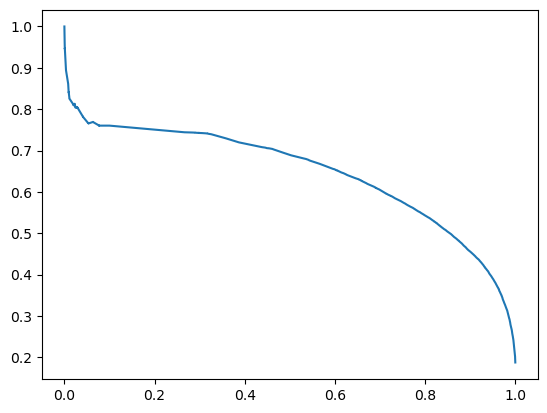

In [16]:
y_score = model_cat.predict_proba(X_test)[:,1]
precision, recall, thresh = precision_recall_curve(y_test, y_score)

plt.plot(recall, precision)

**Подбор порога**

In [17]:
f1_max = -1
thresh_max = -1

for i in tqdm(np.linspace(0.3
                          , 0.45,100)):
    y_pred = np.where(y_score > i, 1, 0)
    f1 = f1_score(y_test, y_pred)
    if f1 > f1_max:
        f1_max = f1
        thresh_max = i
        print(f1_max, thresh_max)


  4%|███▎                                                                              | 4/100 [00:00<00:05, 18.44it/s]

0.6504886030114588 0.3
0.650608140245974 0.3045454545454545


  8%|██████▌                                                                           | 8/100 [00:00<00:05, 18.36it/s]

0.6509034331595743 0.30606060606060603
0.6509133872580205 0.30757575757575756
0.6509825315103368 0.3090909090909091


 14%|███████████▎                                                                     | 14/100 [00:00<00:04, 18.53it/s]

0.650987490262567 0.31666666666666665
0.6511836462513079 0.3181818181818182


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.68it/s]


In [21]:
result = permutation_importance(model_cat, X_test, y_test, n_repeats=20, random_state=2)

In [22]:
dict(zip(X_train.columns, result.importances_mean))

{'регион': -6.038109378865286e-05,
 'использование': 0.00020390992328633283,
 'сумма': 0.0045919326899282464,
 'частота_пополнения': 0.0024778520168275363,
 'доход': 0.0037206137094778547,
 'сегмент_arpu': 0.004784706755753543,
 'частота': 0.009357337292749346,
 'объем_данных': 0.012067557535263562,
 'on_net': 0.017642910170749832,
 'продукт_1': 0.006635733729274934,
 'продукт_2': 0.0018542439990101689,
 'секретный_скор': 0.12059341747092304,
 'pack': 0.0004488987874288641,
 'pack_freq': 0.000776787923781258}

In [24]:
model_cat = CatBoostClassifier(random_state=2, depth=5, eval_metric='F1', cat_features=categ, auto_class_weights='SqrtBalanced')

calibrated_clf = CalibratedClassifierCV(model_cat, cv=3, method='isotonic')
model_cat = calibrated_clf.fit(df.drop('binary_target', axis=1), df['binary_target'])

pred_cat = model_cat.predict(df_test)

Learning rate set to 0.166201
0:	learn: 0.7458976	total: 344ms	remaining: 5m 43s
1:	learn: 0.7428848	total: 657ms	remaining: 5m 27s
2:	learn: 0.7434350	total: 981ms	remaining: 5m 25s
3:	learn: 0.7419506	total: 1.28s	remaining: 5m 17s
4:	learn: 0.7400337	total: 1.59s	remaining: 5m 16s
5:	learn: 0.7406162	total: 1.87s	remaining: 5m 9s
6:	learn: 0.7404257	total: 2.18s	remaining: 5m 9s
7:	learn: 0.7403789	total: 2.46s	remaining: 5m 5s
8:	learn: 0.7407406	total: 2.79s	remaining: 5m 6s
9:	learn: 0.7409212	total: 3.04s	remaining: 5m 1s
10:	learn: 0.7410181	total: 3.33s	remaining: 4m 59s
11:	learn: 0.7410905	total: 3.62s	remaining: 4m 57s
12:	learn: 0.7410050	total: 3.92s	remaining: 4m 57s
13:	learn: 0.7441740	total: 4.19s	remaining: 4m 55s
14:	learn: 0.7436825	total: 4.48s	remaining: 4m 54s
15:	learn: 0.7436363	total: 4.76s	remaining: 4m 52s
16:	learn: 0.7437296	total: 5.01s	remaining: 4m 49s
17:	learn: 0.7438219	total: 5.34s	remaining: 4m 51s
18:	learn: 0.7439467	total: 5.67s	remaining: 4m 5

157:	learn: 0.7449684	total: 51.7s	remaining: 4m 35s
158:	learn: 0.7449902	total: 52s	remaining: 4m 35s
159:	learn: 0.7449612	total: 52.4s	remaining: 4m 35s
160:	learn: 0.7449740	total: 52.8s	remaining: 4m 35s
161:	learn: 0.7449732	total: 53.2s	remaining: 4m 35s
162:	learn: 0.7449796	total: 53.6s	remaining: 4m 35s
163:	learn: 0.7450070	total: 54s	remaining: 4m 35s
164:	learn: 0.7449964	total: 54.4s	remaining: 4m 35s
165:	learn: 0.7450197	total: 54.8s	remaining: 4m 35s
166:	learn: 0.7449933	total: 55.1s	remaining: 4m 35s
167:	learn: 0.7449679	total: 55.5s	remaining: 4m 34s
168:	learn: 0.7449989	total: 55.8s	remaining: 4m 34s
169:	learn: 0.7449715	total: 56.2s	remaining: 4m 34s
170:	learn: 0.7450180	total: 56.5s	remaining: 4m 33s
171:	learn: 0.7450145	total: 56.8s	remaining: 4m 33s
172:	learn: 0.7450596	total: 57.2s	remaining: 4m 33s
173:	learn: 0.7450327	total: 57.6s	remaining: 4m 33s
174:	learn: 0.7450080	total: 57.9s	remaining: 4m 32s
175:	learn: 0.7450129	total: 58.3s	remaining: 4m 3

311:	learn: 0.7459861	total: 1m 47s	remaining: 3m 57s
312:	learn: 0.7459938	total: 1m 47s	remaining: 3m 56s
313:	learn: 0.7459678	total: 1m 48s	remaining: 3m 56s
314:	learn: 0.7459896	total: 1m 48s	remaining: 3m 56s
315:	learn: 0.7459889	total: 1m 48s	remaining: 3m 55s
316:	learn: 0.7459678	total: 1m 49s	remaining: 3m 55s
317:	learn: 0.7459607	total: 1m 49s	remaining: 3m 55s
318:	learn: 0.7459642	total: 1m 50s	remaining: 3m 55s
319:	learn: 0.7459945	total: 1m 50s	remaining: 3m 55s
320:	learn: 0.7460305	total: 1m 51s	remaining: 3m 54s
321:	learn: 0.7460361	total: 1m 51s	remaining: 3m 54s
322:	learn: 0.7460030	total: 1m 51s	remaining: 3m 54s
323:	learn: 0.7460502	total: 1m 52s	remaining: 3m 53s
324:	learn: 0.7460206	total: 1m 52s	remaining: 3m 53s
325:	learn: 0.7460164	total: 1m 52s	remaining: 3m 53s
326:	learn: 0.7460114	total: 1m 53s	remaining: 3m 52s
327:	learn: 0.7460776	total: 1m 53s	remaining: 3m 52s
328:	learn: 0.7461079	total: 1m 53s	remaining: 3m 52s
329:	learn: 0.7461072	total:

464:	learn: 0.7468081	total: 2m 37s	remaining: 3m 1s
465:	learn: 0.7468236	total: 2m 38s	remaining: 3m 1s
466:	learn: 0.7468454	total: 2m 38s	remaining: 3m 1s
467:	learn: 0.7468504	total: 2m 38s	remaining: 3m
468:	learn: 0.7468595	total: 2m 39s	remaining: 3m
469:	learn: 0.7468898	total: 2m 39s	remaining: 3m
470:	learn: 0.7468997	total: 2m 40s	remaining: 2m 59s
471:	learn: 0.7469004	total: 2m 40s	remaining: 2m 59s
472:	learn: 0.7469088	total: 2m 40s	remaining: 2m 59s
473:	learn: 0.7469003	total: 2m 41s	remaining: 2m 58s
474:	learn: 0.7469081	total: 2m 41s	remaining: 2m 58s
475:	learn: 0.7469151	total: 2m 41s	remaining: 2m 58s
476:	learn: 0.7469412	total: 2m 42s	remaining: 2m 57s
477:	learn: 0.7469567	total: 2m 42s	remaining: 2m 57s
478:	learn: 0.7469617	total: 2m 42s	remaining: 2m 57s
479:	learn: 0.7469532	total: 2m 43s	remaining: 2m 56s
480:	learn: 0.7469828	total: 2m 43s	remaining: 2m 56s
481:	learn: 0.7469814	total: 2m 44s	remaining: 2m 56s
482:	learn: 0.7469948	total: 2m 44s	remaini

617:	learn: 0.7478798	total: 3m 34s	remaining: 2m 12s
618:	learn: 0.7478650	total: 3m 35s	remaining: 2m 12s
619:	learn: 0.7478650	total: 3m 35s	remaining: 2m 12s
620:	learn: 0.7479135	total: 3m 35s	remaining: 2m 11s
621:	learn: 0.7478960	total: 3m 36s	remaining: 2m 11s
622:	learn: 0.7479143	total: 3m 36s	remaining: 2m 11s
623:	learn: 0.7479277	total: 3m 36s	remaining: 2m 10s
624:	learn: 0.7479298	total: 3m 37s	remaining: 2m 10s
625:	learn: 0.7479145	total: 3m 37s	remaining: 2m 10s
626:	learn: 0.7479287	total: 3m 38s	remaining: 2m 9s
627:	learn: 0.7479237	total: 3m 38s	remaining: 2m 9s
628:	learn: 0.7479237	total: 3m 38s	remaining: 2m 9s
629:	learn: 0.7479237	total: 3m 39s	remaining: 2m 8s
630:	learn: 0.7479412	total: 3m 39s	remaining: 2m 8s
631:	learn: 0.7479377	total: 3m 39s	remaining: 2m 8s
632:	learn: 0.7479357	total: 3m 40s	remaining: 2m 7s
633:	learn: 0.7479441	total: 3m 40s	remaining: 2m 7s
634:	learn: 0.7479350	total: 3m 40s	remaining: 2m 6s
635:	learn: 0.7479512	total: 3m 41s	r

771:	learn: 0.7486751	total: 4m 28s	remaining: 1m 19s
772:	learn: 0.7486694	total: 4m 28s	remaining: 1m 18s
773:	learn: 0.7486702	total: 4m 29s	remaining: 1m 18s
774:	learn: 0.7486841	total: 4m 29s	remaining: 1m 18s
775:	learn: 0.7487011	total: 4m 30s	remaining: 1m 17s
776:	learn: 0.7486828	total: 4m 30s	remaining: 1m 17s
777:	learn: 0.7486730	total: 4m 30s	remaining: 1m 17s
778:	learn: 0.7486877	total: 4m 31s	remaining: 1m 16s
779:	learn: 0.7486906	total: 4m 31s	remaining: 1m 16s
780:	learn: 0.7486863	total: 4m 31s	remaining: 1m 16s
781:	learn: 0.7486800	total: 4m 32s	remaining: 1m 15s
782:	learn: 0.7486898	total: 4m 32s	remaining: 1m 15s
783:	learn: 0.7486828	total: 4m 32s	remaining: 1m 15s
784:	learn: 0.7486709	total: 4m 33s	remaining: 1m 14s
785:	learn: 0.7486509	total: 4m 33s	remaining: 1m 14s
786:	learn: 0.7486375	total: 4m 33s	remaining: 1m 14s
787:	learn: 0.7486417	total: 4m 34s	remaining: 1m 13s
788:	learn: 0.7486543	total: 4m 34s	remaining: 1m 13s
789:	learn: 0.7486642	total:

927:	learn: 0.7495533	total: 5m 23s	remaining: 25.1s
928:	learn: 0.7495281	total: 5m 23s	remaining: 24.7s
929:	learn: 0.7495013	total: 5m 23s	remaining: 24.4s
930:	learn: 0.7495147	total: 5m 24s	remaining: 24s
931:	learn: 0.7495272	total: 5m 24s	remaining: 23.7s
932:	learn: 0.7495098	total: 5m 24s	remaining: 23.3s
933:	learn: 0.7494887	total: 5m 25s	remaining: 23s
934:	learn: 0.7495028	total: 5m 25s	remaining: 22.6s
935:	learn: 0.7495295	total: 5m 25s	remaining: 22.3s
936:	learn: 0.7495211	total: 5m 26s	remaining: 21.9s
937:	learn: 0.7495161	total: 5m 26s	remaining: 21.6s
938:	learn: 0.7495077	total: 5m 26s	remaining: 21.2s
939:	learn: 0.7495189	total: 5m 27s	remaining: 20.9s
940:	learn: 0.7495182	total: 5m 27s	remaining: 20.5s
941:	learn: 0.7495237	total: 5m 27s	remaining: 20.2s
942:	learn: 0.7495556	total: 5m 28s	remaining: 19.8s
943:	learn: 0.7495544	total: 5m 28s	remaining: 19.5s
944:	learn: 0.7495701	total: 5m 28s	remaining: 19.1s
945:	learn: 0.7496023	total: 5m 29s	remaining: 18.

84:	learn: 0.7414252	total: 28s	remaining: 5m 1s
85:	learn: 0.7414972	total: 28.4s	remaining: 5m 1s
86:	learn: 0.7415534	total: 28.7s	remaining: 5m 1s
87:	learn: 0.7415757	total: 29s	remaining: 5m
88:	learn: 0.7425089	total: 29.4s	remaining: 5m
89:	learn: 0.7425607	total: 29.7s	remaining: 4m 59s
90:	learn: 0.7425919	total: 30.1s	remaining: 5m
91:	learn: 0.7426111	total: 30.4s	remaining: 5m
92:	learn: 0.7434204	total: 30.7s	remaining: 4m 59s
93:	learn: 0.7434739	total: 31s	remaining: 4m 58s
94:	learn: 0.7434351	total: 31.3s	remaining: 4m 58s
95:	learn: 0.7434684	total: 31.7s	remaining: 4m 58s
96:	learn: 0.7434825	total: 32s	remaining: 4m 58s
97:	learn: 0.7445376	total: 32.3s	remaining: 4m 57s
98:	learn: 0.7446053	total: 32.6s	remaining: 4m 56s
99:	learn: 0.7435352	total: 32.9s	remaining: 4m 56s
100:	learn: 0.7435790	total: 33.3s	remaining: 4m 56s
101:	learn: 0.7437434	total: 33.6s	remaining: 4m 56s
102:	learn: 0.7437603	total: 34s	remaining: 4m 55s
103:	learn: 0.7436063	total: 34.3s	rem

240:	learn: 0.7455385	total: 1m 20s	remaining: 4m 12s
241:	learn: 0.7455371	total: 1m 20s	remaining: 4m 12s
242:	learn: 0.7455322	total: 1m 20s	remaining: 4m 11s
243:	learn: 0.7455462	total: 1m 21s	remaining: 4m 11s
244:	learn: 0.7455441	total: 1m 21s	remaining: 4m 10s
245:	learn: 0.7455469	total: 1m 21s	remaining: 4m 10s
246:	learn: 0.7456189	total: 1m 22s	remaining: 4m 10s
247:	learn: 0.7455603	total: 1m 22s	remaining: 4m 10s
248:	learn: 0.7455652	total: 1m 22s	remaining: 4m 9s
249:	learn: 0.7456033	total: 1m 23s	remaining: 4m 9s
250:	learn: 0.7455955	total: 1m 23s	remaining: 4m 9s
251:	learn: 0.7455792	total: 1m 23s	remaining: 4m 8s
252:	learn: 0.7456138	total: 1m 24s	remaining: 4m 8s
253:	learn: 0.7455474	total: 1m 24s	remaining: 4m 7s
254:	learn: 0.7455234	total: 1m 24s	remaining: 4m 7s
255:	learn: 0.7455248	total: 1m 25s	remaining: 4m 7s
256:	learn: 0.7455459	total: 1m 25s	remaining: 4m 7s
257:	learn: 0.7455890	total: 1m 25s	remaining: 4m 6s
258:	learn: 0.7456215	total: 1m 26s	re

394:	learn: 0.7459152	total: 2m 13s	remaining: 3m 25s
395:	learn: 0.7459222	total: 2m 14s	remaining: 3m 24s
396:	learn: 0.7459413	total: 2m 14s	remaining: 3m 24s
397:	learn: 0.7459738	total: 2m 14s	remaining: 3m 24s
398:	learn: 0.7460007	total: 2m 15s	remaining: 3m 23s
399:	learn: 0.7460226	total: 2m 15s	remaining: 3m 23s
400:	learn: 0.7460226	total: 2m 16s	remaining: 3m 23s
401:	learn: 0.7460084	total: 2m 16s	remaining: 3m 22s
402:	learn: 0.7460084	total: 2m 16s	remaining: 3m 22s
403:	learn: 0.7460155	total: 2m 17s	remaining: 3m 22s
404:	learn: 0.7460657	total: 2m 17s	remaining: 3m 21s
405:	learn: 0.7460537	total: 2m 17s	remaining: 3m 21s
406:	learn: 0.7460862	total: 2m 18s	remaining: 3m 21s
407:	learn: 0.7460932	total: 2m 18s	remaining: 3m 20s
408:	learn: 0.7460960	total: 2m 18s	remaining: 3m 20s
409:	learn: 0.7460833	total: 2m 19s	remaining: 3m 20s
410:	learn: 0.7460777	total: 2m 19s	remaining: 3m 20s
411:	learn: 0.7461003	total: 2m 19s	remaining: 3m 19s
412:	learn: 0.7460918	total:

547:	learn: 0.7469959	total: 3m 3s	remaining: 2m 31s
548:	learn: 0.7469959	total: 3m 3s	remaining: 2m 30s
549:	learn: 0.7469854	total: 3m 3s	remaining: 2m 30s
550:	learn: 0.7469834	total: 3m 4s	remaining: 2m 30s
551:	learn: 0.7469792	total: 3m 4s	remaining: 2m 29s
552:	learn: 0.7469749	total: 3m 4s	remaining: 2m 29s
553:	learn: 0.7469636	total: 3m 5s	remaining: 2m 29s
554:	learn: 0.7469671	total: 3m 5s	remaining: 2m 28s
555:	learn: 0.7470116	total: 3m 5s	remaining: 2m 28s
556:	learn: 0.7470166	total: 3m 6s	remaining: 2m 28s
557:	learn: 0.7470419	total: 3m 6s	remaining: 2m 27s
558:	learn: 0.7469996	total: 3m 6s	remaining: 2m 27s
559:	learn: 0.7470060	total: 3m 7s	remaining: 2m 27s
560:	learn: 0.7469919	total: 3m 7s	remaining: 2m 26s
561:	learn: 0.7469904	total: 3m 7s	remaining: 2m 26s
562:	learn: 0.7470194	total: 3m 8s	remaining: 2m 25s
563:	learn: 0.7470279	total: 3m 8s	remaining: 2m 25s
564:	learn: 0.7470384	total: 3m 8s	remaining: 2m 25s
565:	learn: 0.7470236	total: 3m 9s	remaining: 

700:	learn: 0.7476434	total: 3m 50s	remaining: 1m 38s
701:	learn: 0.7476448	total: 3m 51s	remaining: 1m 38s
702:	learn: 0.7476525	total: 3m 51s	remaining: 1m 37s
703:	learn: 0.7476243	total: 3m 51s	remaining: 1m 37s
704:	learn: 0.7476455	total: 3m 52s	remaining: 1m 37s
705:	learn: 0.7476708	total: 3m 52s	remaining: 1m 36s
706:	learn: 0.7477307	total: 3m 52s	remaining: 1m 36s
707:	learn: 0.7477421	total: 3m 53s	remaining: 1m 36s
708:	learn: 0.7477420	total: 3m 53s	remaining: 1m 35s
709:	learn: 0.7477420	total: 3m 53s	remaining: 1m 35s
710:	learn: 0.7477272	total: 3m 54s	remaining: 1m 35s
711:	learn: 0.7477357	total: 3m 54s	remaining: 1m 34s
712:	learn: 0.7477561	total: 3m 54s	remaining: 1m 34s
713:	learn: 0.7477455	total: 3m 55s	remaining: 1m 34s
714:	learn: 0.7477272	total: 3m 55s	remaining: 1m 33s
715:	learn: 0.7477216	total: 3m 55s	remaining: 1m 33s
716:	learn: 0.7476983	total: 3m 55s	remaining: 1m 33s
717:	learn: 0.7477194	total: 3m 56s	remaining: 1m 32s
718:	learn: 0.7477300	total:

855:	learn: 0.7484724	total: 4m 39s	remaining: 47s
856:	learn: 0.7484584	total: 4m 39s	remaining: 46.7s
857:	learn: 0.7484624	total: 4m 40s	remaining: 46.3s
858:	learn: 0.7484688	total: 4m 40s	remaining: 46s
859:	learn: 0.7484864	total: 4m 40s	remaining: 45.7s
860:	learn: 0.7484842	total: 4m 40s	remaining: 45.4s
861:	learn: 0.7484414	total: 4m 41s	remaining: 45s
862:	learn: 0.7484738	total: 4m 41s	remaining: 44.7s
863:	learn: 0.7484653	total: 4m 41s	remaining: 44.4s
864:	learn: 0.7484830	total: 4m 42s	remaining: 44s
865:	learn: 0.7484900	total: 4m 42s	remaining: 43.7s
866:	learn: 0.7484921	total: 4m 42s	remaining: 43.4s
867:	learn: 0.7485195	total: 4m 43s	remaining: 43.1s
868:	learn: 0.7484634	total: 4m 43s	remaining: 42.7s
869:	learn: 0.7484177	total: 4m 43s	remaining: 42.4s
870:	learn: 0.7484382	total: 4m 43s	remaining: 42s
871:	learn: 0.7484241	total: 4m 44s	remaining: 41.7s
872:	learn: 0.7484235	total: 4m 44s	remaining: 41.4s
873:	learn: 0.7484129	total: 4m 44s	remaining: 41.1s
874

11:	learn: 0.7449115	total: 3.74s	remaining: 5m 8s
12:	learn: 0.7450252	total: 4.09s	remaining: 5m 10s
13:	learn: 0.7447350	total: 4.44s	remaining: 5m 13s
14:	learn: 0.7447667	total: 4.77s	remaining: 5m 13s
15:	learn: 0.7446934	total: 5.13s	remaining: 5m 15s
16:	learn: 0.7441746	total: 5.45s	remaining: 5m 15s
17:	learn: 0.7445834	total: 5.76s	remaining: 5m 14s
18:	learn: 0.7448163	total: 6.11s	remaining: 5m 15s
19:	learn: 0.7441990	total: 6.42s	remaining: 5m 14s
20:	learn: 0.7441108	total: 6.77s	remaining: 5m 15s
21:	learn: 0.7440474	total: 7.09s	remaining: 5m 15s
22:	learn: 0.7443348	total: 7.46s	remaining: 5m 16s
23:	learn: 0.7443462	total: 7.82s	remaining: 5m 17s
24:	learn: 0.7443673	total: 8.1s	remaining: 5m 15s
25:	learn: 0.7445882	total: 8.41s	remaining: 5m 14s
26:	learn: 0.7446102	total: 8.65s	remaining: 5m 11s
27:	learn: 0.7446403	total: 9s	remaining: 5m 12s
28:	learn: 0.7446557	total: 9.28s	remaining: 5m 10s
29:	learn: 0.7446065	total: 9.69s	remaining: 5m 13s
30:	learn: 0.7446

169:	learn: 0.7455504	total: 55.9s	remaining: 4m 33s
170:	learn: 0.7455413	total: 56.2s	remaining: 4m 32s
171:	learn: 0.7455399	total: 56.6s	remaining: 4m 32s
172:	learn: 0.7456385	total: 56.9s	remaining: 4m 32s
173:	learn: 0.7456181	total: 57.3s	remaining: 4m 31s
174:	learn: 0.7456159	total: 57.6s	remaining: 4m 31s
175:	learn: 0.7456124	total: 58s	remaining: 4m 31s
176:	learn: 0.7456223	total: 58.4s	remaining: 4m 31s
177:	learn: 0.7456188	total: 58.7s	remaining: 4m 31s
178:	learn: 0.7456273	total: 59s	remaining: 4m 30s
179:	learn: 0.7457012	total: 59.3s	remaining: 4m 30s
180:	learn: 0.7457308	total: 59.7s	remaining: 4m 30s
181:	learn: 0.7457181	total: 1m	remaining: 4m 29s
182:	learn: 0.7456716	total: 1m	remaining: 4m 29s
183:	learn: 0.7456194	total: 1m	remaining: 4m 29s
184:	learn: 0.7456405	total: 1m 1s	remaining: 4m 29s
185:	learn: 0.7456286	total: 1m 1s	remaining: 4m 28s
186:	learn: 0.7456271	total: 1m 1s	remaining: 4m 28s
187:	learn: 0.7456159	total: 1m 1s	remaining: 4m 27s
188:	l

323:	learn: 0.7467278	total: 1m 50s	remaining: 3m 50s
324:	learn: 0.7467328	total: 1m 50s	remaining: 3m 50s
325:	learn: 0.7467469	total: 1m 51s	remaining: 3m 49s
326:	learn: 0.7467469	total: 1m 51s	remaining: 3m 49s
327:	learn: 0.7467652	total: 1m 51s	remaining: 3m 49s
328:	learn: 0.7467723	total: 1m 52s	remaining: 3m 49s
329:	learn: 0.7467173	total: 1m 52s	remaining: 3m 48s
330:	learn: 0.7467525	total: 1m 53s	remaining: 3m 48s
331:	learn: 0.7467223	total: 1m 53s	remaining: 3m 48s
332:	learn: 0.7467201	total: 1m 53s	remaining: 3m 48s
333:	learn: 0.7467463	total: 1m 54s	remaining: 3m 47s
334:	learn: 0.7467456	total: 1m 54s	remaining: 3m 47s
335:	learn: 0.7467245	total: 1m 55s	remaining: 3m 47s
336:	learn: 0.7467899	total: 1m 55s	remaining: 3m 46s
337:	learn: 0.7467836	total: 1m 55s	remaining: 3m 46s
338:	learn: 0.7467498	total: 1m 56s	remaining: 3m 46s
339:	learn: 0.7467611	total: 1m 56s	remaining: 3m 45s
340:	learn: 0.7467301	total: 1m 56s	remaining: 3m 45s
341:	learn: 0.7467294	total:

476:	learn: 0.7474176	total: 2m 44s	remaining: 3m
477:	learn: 0.7474049	total: 2m 44s	remaining: 2m 59s
478:	learn: 0.7474345	total: 2m 44s	remaining: 2m 59s
479:	learn: 0.7474718	total: 2m 45s	remaining: 2m 59s
480:	learn: 0.7474965	total: 2m 45s	remaining: 2m 58s
481:	learn: 0.7474973	total: 2m 45s	remaining: 2m 58s
482:	learn: 0.7475106	total: 2m 46s	remaining: 2m 58s
483:	learn: 0.7475176	total: 2m 46s	remaining: 2m 57s
484:	learn: 0.7475155	total: 2m 46s	remaining: 2m 57s
485:	learn: 0.7474895	total: 2m 47s	remaining: 2m 56s
486:	learn: 0.7474861	total: 2m 47s	remaining: 2m 56s
487:	learn: 0.7474995	total: 2m 48s	remaining: 2m 56s
488:	learn: 0.7474833	total: 2m 48s	remaining: 2m 55s
489:	learn: 0.7474952	total: 2m 48s	remaining: 2m 55s
490:	learn: 0.7474945	total: 2m 48s	remaining: 2m 55s
491:	learn: 0.7474720	total: 2m 49s	remaining: 2m 54s
492:	learn: 0.7474487	total: 2m 49s	remaining: 2m 54s
493:	learn: 0.7474747	total: 2m 49s	remaining: 2m 54s
494:	learn: 0.7474775	total: 2m 

629:	learn: 0.7483098	total: 3m 36s	remaining: 2m 7s
630:	learn: 0.7483323	total: 3m 36s	remaining: 2m 6s
631:	learn: 0.7483141	total: 3m 36s	remaining: 2m 6s
632:	learn: 0.7483141	total: 3m 37s	remaining: 2m 5s
633:	learn: 0.7482754	total: 3m 37s	remaining: 2m 5s
634:	learn: 0.7482740	total: 3m 37s	remaining: 2m 5s
635:	learn: 0.7482620	total: 3m 38s	remaining: 2m 4s
636:	learn: 0.7482620	total: 3m 38s	remaining: 2m 4s
637:	learn: 0.7482487	total: 3m 38s	remaining: 2m 4s
638:	learn: 0.7482564	total: 3m 39s	remaining: 2m 3s
639:	learn: 0.7482215	total: 3m 39s	remaining: 2m 3s
640:	learn: 0.7482173	total: 3m 39s	remaining: 2m 3s
641:	learn: 0.7482180	total: 3m 40s	remaining: 2m 2s
642:	learn: 0.7482313	total: 3m 40s	remaining: 2m 2s
643:	learn: 0.7482017	total: 3m 40s	remaining: 2m 2s
644:	learn: 0.7482404	total: 3m 41s	remaining: 2m 1s
645:	learn: 0.7482532	total: 3m 41s	remaining: 2m 1s
646:	learn: 0.7482616	total: 3m 41s	remaining: 2m
647:	learn: 0.7482771	total: 3m 41s	remaining: 2m

782:	learn: 0.7489687	total: 4m 29s	remaining: 1m 14s
783:	learn: 0.7489743	total: 4m 29s	remaining: 1m 14s
784:	learn: 0.7489778	total: 4m 29s	remaining: 1m 13s
785:	learn: 0.7489567	total: 4m 30s	remaining: 1m 13s
786:	learn: 0.7489960	total: 4m 30s	remaining: 1m 13s
787:	learn: 0.7489954	total: 4m 30s	remaining: 1m 12s
788:	learn: 0.7489820	total: 4m 30s	remaining: 1m 12s
789:	learn: 0.7489863	total: 4m 31s	remaining: 1m 12s
790:	learn: 0.7490045	total: 4m 31s	remaining: 1m 11s
791:	learn: 0.7490052	total: 4m 31s	remaining: 1m 11s
792:	learn: 0.7489855	total: 4m 32s	remaining: 1m 11s
793:	learn: 0.7489861	total: 4m 32s	remaining: 1m 10s
794:	learn: 0.7490008	total: 4m 32s	remaining: 1m 10s
795:	learn: 0.7489966	total: 4m 33s	remaining: 1m 10s
796:	learn: 0.7489805	total: 4m 33s	remaining: 1m 9s
797:	learn: 0.7489783	total: 4m 33s	remaining: 1m 9s
798:	learn: 0.7489637	total: 4m 34s	remaining: 1m 8s
799:	learn: 0.7489604	total: 4m 34s	remaining: 1m 8s
800:	learn: 0.7489674	total: 4m 

938:	learn: 0.7497060	total: 5m 19s	remaining: 20.8s
939:	learn: 0.7497089	total: 5m 20s	remaining: 20.4s
940:	learn: 0.7497138	total: 5m 20s	remaining: 20.1s
941:	learn: 0.7497152	total: 5m 20s	remaining: 19.7s
942:	learn: 0.7497180	total: 5m 21s	remaining: 19.4s
943:	learn: 0.7497201	total: 5m 21s	remaining: 19.1s
944:	learn: 0.7497279	total: 5m 21s	remaining: 18.7s
945:	learn: 0.7497245	total: 5m 22s	remaining: 18.4s
946:	learn: 0.7497302	total: 5m 22s	remaining: 18s
947:	learn: 0.7497259	total: 5m 22s	remaining: 17.7s
948:	learn: 0.7497133	total: 5m 22s	remaining: 17.4s
949:	learn: 0.7497288	total: 5m 23s	remaining: 17s
950:	learn: 0.7497386	total: 5m 23s	remaining: 16.7s
951:	learn: 0.7497477	total: 5m 23s	remaining: 16.3s
952:	learn: 0.7497758	total: 5m 24s	remaining: 16s
953:	learn: 0.7497808	total: 5m 24s	remaining: 15.6s
954:	learn: 0.7497647	total: 5m 24s	remaining: 15.3s
955:	learn: 0.7497814	total: 5m 25s	remaining: 15s
956:	learn: 0.7497779	total: 5m 25s	remaining: 14.6s
9

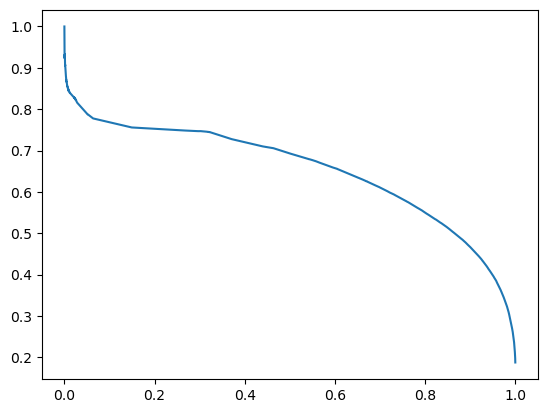

In [25]:
y_score = model_cat.predict_proba(df.drop('binary_target', axis=1))[:,1]
precision, recall, thresh = precision_recall_curve(df['binary_target'], y_score)

plt.plot(recall, precision)

In [26]:
f1_max = -1
thresh_max = -1

for i in tqdm(np.linspace(0.31, 0.34,100)):
    y_pred = np.where(y_score > i, 1, 0)
    f1 = f1_score(df['binary_target'], y_pred)
    if f1 > f1_max:
        f1_max = f1
        thresh_max = i
        print(f1_max, thresh_max)


  1%|▊                                                                                 | 1/100 [00:00<00:32,  3.08it/s]

0.6554515033406304 0.31


  2%|█▋                                                                                | 2/100 [00:00<00:31,  3.16it/s]

0.6554732885294453 0.3103030303030303


  5%|████                                                                              | 5/100 [00:01<00:30,  3.08it/s]

0.6555553526925499 0.3112121212121212


  6%|████▉                                                                             | 6/100 [00:01<00:29,  3.14it/s]

0.6555651415763983 0.3115151515151515


  7%|█████▋                                                                            | 7/100 [00:02<00:29,  3.16it/s]

0.6555906342238446 0.3118181818181818


  9%|███████▍                                                                          | 9/100 [00:02<00:28,  3.19it/s]

0.6556037632444283 0.31242424242424244


 10%|████████                                                                         | 10/100 [00:03<00:27,  3.24it/s]

0.6556077060993296 0.31272727272727274


 11%|████████▉                                                                        | 11/100 [00:03<00:27,  3.22it/s]

0.6556329358236126 0.31303030303030305


 13%|██████████▌                                                                      | 13/100 [00:04<00:26,  3.26it/s]

0.655633526127756 0.31363636363636366


 15%|████████████▏                                                                    | 15/100 [00:04<00:26,  3.25it/s]

0.6556539190341332 0.31424242424242427


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.17it/s]


**Формирование сабмишена**

In [27]:
pred_cat = model_cat.predict_proba(df_test)[:,1]
pred_cat = np.where(pred_cat > thresh_max, 1, 0)

samp = pd.read_csv('sample_submission.csv')
submission = {
    'client_id': samp['client_id'],
    'preds': pred_cat
}
solution = pd.DataFrame(submission)
solution.to_csv('final_submission.csv',index=False)